# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Baibhav Datta (230059246) - PG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/CW_Folder_PG/CW_Dataset/'

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

#Copy video to colab session
!cp -r '/content/drive/MyDrive/CW_Folder_PG/Video' .

### Load packages

In the next cell you should load all the packages required to test your functions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

import pickle
import torch
import cv2
from PIL import Image
from matplotlib import rc
import matplotlib.animation as animation
import matplotlib
from skimage import color
from skimage.transform import resize
from skimage.feature import hog
import random
import torchvision
import time
import re

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

In [38]:
hogsvm = load(os.path.join('/content/drive/MyDrive/CW_Folder_PG/','Models','svmmodel.pkl'))
hogmlp = load(os.path.join('/content/drive/MyDrive/CW_Folder_PG/','Models','mlpmodel.pkl'))
cnn = torch.load(os.path.join('/content/drive/MyDrive/CW_Folder_PG/','Models','cnnmodel.pth'),map_location=torch.device('cpu'))
cnn.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/CW_Folder_PG/','Models','cnn_state_dict.pth'),map_location=torch.device('cpu')))

<All keys matched successfully>

## Functions to be called in MaskDetection and MaskDetectionVideo functions

The following functions are adapted from Lab Tutorial 08 of the Computer Vision Module(IN3060/INM460) authored by Giacomo Tarroni. I have made required changes according to the needs of the current task.


*   testimshow
*   visualize_model_test




In [39]:
def calc_avg_mean_std(img_names, img_root):
    mean_sum = np.array([0., 0., 0.])
    std_sum = np.array([0., 0., 0.])
    n_images = len(img_names)
    for img_name in img_names:
        img = cv2.imread(img_root + img_name)
        mean, std = cv2.meanStdDev(img)
        mean_sum += np.squeeze(mean)
        std_sum += np.squeeze(std)
    return (mean_sum / n_images, std_sum / n_images)

def testimshow(inp,path_to_testset, title=None):
    """Imshow for Tensor."""
    testimgpath=path_to_testset+'images/'
    imgnames = [f for f in sorted(os.listdir(testimgpath)) if os.path.isfile(os.path.join(testimgpath, f))]
    test_data_means,test_data_stds=calc_avg_mean_std(imgnames,testimgpath)

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(test_data_stds) * inp + np.asarray(test_data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model_test(path_to_testset,model, num_images=4):
    dataloaders = torch.load(os.path.join('/content/drive/MyDrive/CW_Folder_PG/','CW_Dataset','dataloader.pth'))
    class_names=['0', '1', '2']
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(torch.device("cpu"))
            labels = labels.to(torch.device("cpu"))

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            plt.figure(figsize=(8, 6))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                actual=int(labels[j].item())
                pred=int(class_names[preds[j]])
                ax.set_title(f"Actual:{lbldict[actual]}, Predicted:{lbldict[pred]} ",fontsize = 10)
                testimshow(inputs.cpu().data[j],path_to_testset)        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def hog_extraction(img):
  face_gray = color.rgb2gray(img)
  resized_face=resize(face_gray, (128,64))
  ppc = 16

  fd,hog_image = hog(resized_face, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2,2),visualize=True)

  return fd,hog_image

# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [27]:
lbldict={0:"No mask",1:"With mask",2:"Improper mask"}

#Function to visualise the predictions obtained by the different models on the test set images
def MaskDetect(path_to_testset,model):

  if type(model).__name__!="ResNet":
    num=[int(re.findall(r'\d+',l)[0]) for l in os.listdir(os.path.join(path_to_testset,'images/'))]
    index=random.sample(num,4)                                      #generating 4 random indexes of test set
    testlabels=[]
    test_images=[]

    #loading the randomly selected images and their labels
    for i in index:
      path=path_to_testset+'labels/image_'+str(i)+'.txt'
      file=open(path,"r")
      content=file.read()
      testlabels.append(content)
      img=Image.open(path_to_testset+'images/image_'+str(i)+'.jpeg')
      test_images.append(img)

    hog_features_test = []
    for img in test_images:
      fd,hog_image = hog_extraction(img)
      hog_features_test.append(fd)

    labels_test =  np.array(testlabels).reshape(len(testlabels),1)
    y_pred = model.predict(hog_features_test)

    plt.figure(figsize=(8, 6))
    c=0

    for i in index:
      ax = plt.subplot(2, 2, c + 1)
      plt.imshow(test_images[c])
      actual=int(labels_test[c].item())
      pred=int(y_pred[c])
      ax.set_title(f"Actual:{lbldict[actual]}, Predicted:{lbldict[pred]}",fontsize = 10)
      c+=1
      plt.axis('off')

  elif type(model).__name__=="ResNet":
    visualize_model_test(path_to_testset,model)


Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

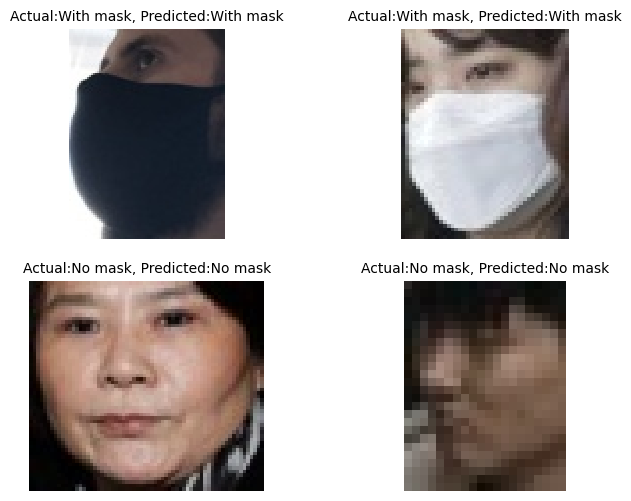

In [28]:
testpath='CW_Dataset/test/'
MaskDetect(testpath,hogsvm)

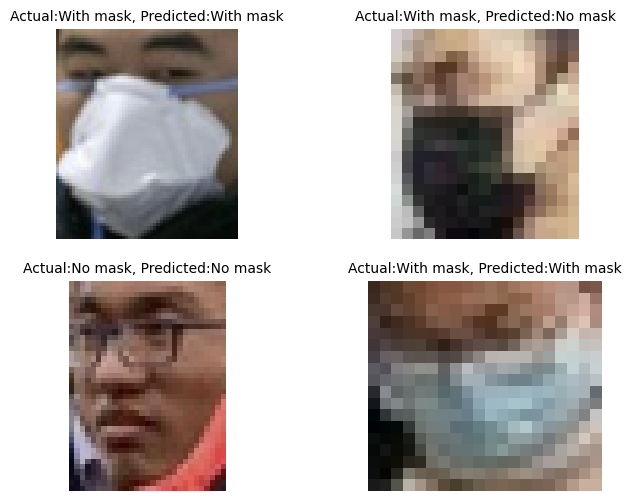

In [29]:
MaskDetect(testpath,hogmlp)

  self.pid = os.fork()



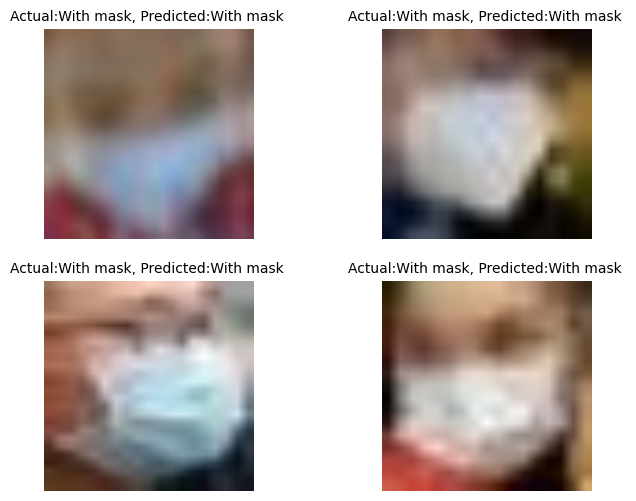

In [40]:
MaskDetect(testpath,cnn)

# Test MaskDetectionVideo

This section should allow a quick test of the `MaskDetectionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetectionVideo` work.

In [41]:
def MaskDetectionVideo(video):
  cap = cv2.VideoCapture(os.path.join('/content/drive/MyDrive/CW_Folder_PG/Video', video))
  lbldict={0:"No mask",1:"With mask",2:"Improper mask"}
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
  fc = 0
  ret = True
  while fc < frameCount and ret:
      ret, video[fc] = cap.read()
      video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB)
      fc += 1
  cap.release()

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  fcd=video
  font = cv2.FONT_HERSHEY_SIMPLEX
  height, width, channels = video[0,:,:,:].shape
  #iterating through the video frames to detect faces and feeding it to the model for class prediction
  for i in range(fcd.shape[0]):
    img=fcd[i,:,:,:]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    for (x, y, w, h) in faces:
      face_image = Image.fromarray(img[max(0, y):min(height, y+h), max(0, x):min(width, x+w)])
      hog_features,hog_images=hog_extraction(face_image)
      face_pred = hogmlp.predict(hog_features.reshape(1,-1))
      fcd[i,:,:,:]=cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
      lbl=int(face_pred[0])
      fcd[i,:,:,:]=cv2.putText(img, lbldict[lbl], (x+5,y-5), font, 1, (255,255,255), 2)

  #saving 400 frames of the video with predicted classes as
  rc('animation', html='jshtml')
  fig, ax = plt.subplots(figsize=(5, 3))
  x=fcd[1500:1900,:,:,:]
  def frame(i):
      ax.clear()
      ax.axis('off')
      fig.tight_layout()
      plot=ax.imshow(x[i, :, :, :])
      return plot
  anim = animation.FuncAnimation(fig, frame, frames=400)
  writervideo = animation.FFMpegWriter(fps=30)
  anim.save('maskdetect.mp4', writer=writervideo)

Then, make a call to the `MaskDetectionVideo` function to see what results it produces.

Elapsed Time - 244.37593626976013


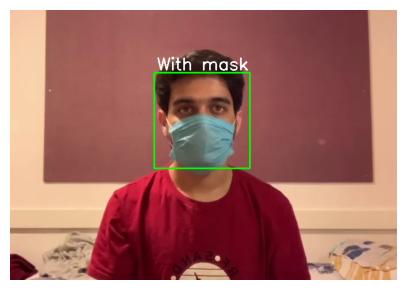

In [26]:
t=time.time()
MaskDetectionVideo('mask.mp4')
print(f"Elapsed Time - {time.time()-t}")

In [31]:
import moviepy.editor
moviepy.editor.ipython_display("maskdetect.mp4")